In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv('../data/singa.csv')
nltk_stem = SnowballStemmer("english")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/andrej/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Ниже предобработка текста. 
Регулярным выражением уберем пунктуацию, через stop_words nltk уберем лишнее, а для стемминга воспользуемся Snowball из nltk. 

In [3]:
import re
def shave_string(text):
    regex_shave = re.sub('[()-:?!,.\"\'\n]', '', str(text)).lower().split()
    stop_shave = [w for w in regex_shave if not w in stop_words]
    stem_shave = map(nltk_stem.stem, stop_shave)
    return ' '.join(stem_shave)

In [4]:
test = "..How about that prick's face when we saw the gyatt??"
shave_string(test)

'prick face saw gyatt'

,rating,text,title,all text
0,3,use airlin go singapor london heathrow issu ti...,ok,use airlin go singapor london heathrow issu ti...
1,5,servic singapor airlin suit class noth excel c...,servic suit class make one feel like vip,servic singapor airlin suit class noth excel c...
2,1,book paid receiv email confirm extra legroom s...,don't give money,book paid receiv email confirm extra legroom s...
3,5,best airlin world seat food servic brilliant c...,best airlin world,best airlin world seat food servic brilliant c...
4,2,premium economi seat singapor airlin narrow se...,premium economi seat singapor airlin worth money,premium economi seat singapor airlin narrow se...


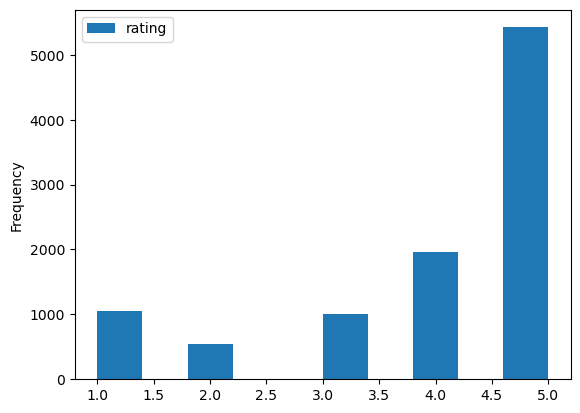

In [5]:
data = data.loc[:,['rating','text','title']]
data['text'] = data['text'].apply(shave_string)
data['title'] = data['title'].apply(shave_string)
data['all text'] = data['text'].astype(str) + data['title']
data.plot.hist()
data.head(5)

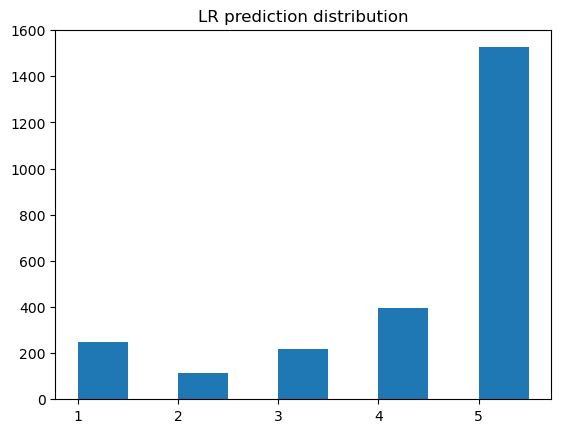

0.6683966738096527 - результат логистической регрессии + bag of words.
0.7143770319222276 - результат логистической регрессии + TD-IDF.


In [6]:
train, test = train_test_split(data, random_state=1)
ranks = [1,1.5,2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]
bow = CountVectorizer()
x_train = bow.fit_transform(train['all text'])
x_test = bow.transform(test['all text'])
y_train = train['rating']
y_test = test['rating']
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
plt.hist(y_pred, ranks)
plt.title("LR prediction distribution")
plt.show()
print(f'{f1_score(y_pred, y_test, average="weighted")} - результат логистической регрессии + bag of words.')
bow = TfidfVectorizer()
x_train = bow.fit_transform(train['all text'])
x_test = bow.transform(test['all text'])
y_train = train['rating']
y_test = test['rating']
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f'{f1_score(y_pred, y_test, average="weighted")} - результат логистической регрессии + TD-IDF.')

TF-IDF показал себя лучше (он и более сложный), продолжим его использовать.

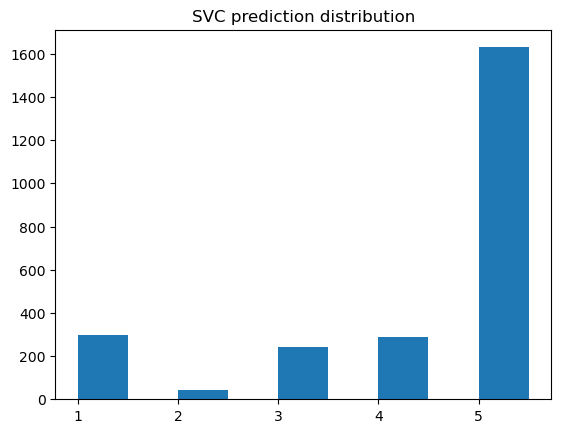

0.7087243232034052 - результат линейного SVC + TD-IDF.


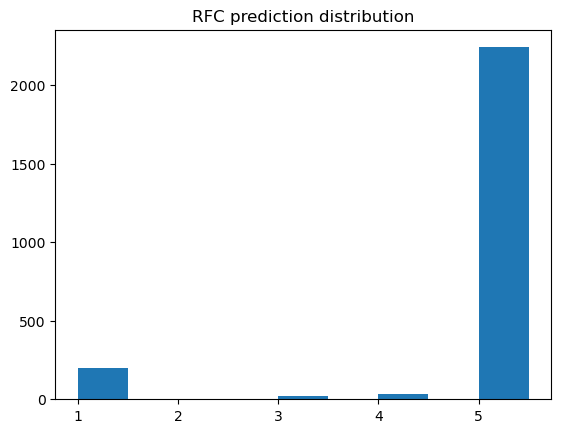

0.7171176264526471 - результат случайных лесов + TD-IDF.


In [7]:
from sklearn.svm import SVC
model = SVC(kernel='linear', max_iter=20000)
model.fit(x_train, y_train)
lin_pred = model.predict(x_test)
plt.hist(lin_pred, ranks)
plt.title("SVC prediction distribution")
plt.show()
print(f'{f1_score(lin_pred, y_test, average = "weighted")} - результат линейного SVC + TD-IDF.')
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(x_train,y_train)
rfc_pred = model.predict(x_test)
plt.hist(rfc_pred, ranks)
plt.title("RFC prediction distribution")
plt.show()
print(f'{f1_score(rfc_pred, y_test, average = "weighted")} - результат случайных лесов + TD-IDF.')


In [8]:
model = SVC(kernel='linear', max_iter=20000)
model.fit(x_train, y_train)
g_text = "The flight was pleasant. We were offered free place in business class suite. Sausage rolls were delicious. Best company"
b_text = "Kick that nigger bitch of the plane! Damn, i hated my flight. Food was awful, it was cold, they scammed me for place in business seat. Worst company,dont give them money." 
g_vec = bow.transform([g_text])
b_vec = bow.transform([b_text])
g_res = model.predict(g_vec)
b_res = model.predict(b_vec)
print(g_res, b_res)                      

[5] [1]


Ключевые слова помогают модели распознать отзыв. Good.